In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt; plt.rc('font', size=14)
import matplotlib.cm as cm
import seaborn as sns
from scipy.spatial import procrustes
from scipy.stats import percentileofscore
from mlxtend.evaluate import permutation_test
import re
from collections import Counter

In [25]:
taxa = ['B_caccae',
        'B_cellulosilyticus_WH2',
        'B_ovatus',
        'B_thetaiotaomicron',
        'B_uniformis',
        'B_vulgatus',
        'C_aerofaciens',
        'C_scindens',
        'C_spiroforme',
        # 'D_longicatena',
        'P_distasonis',
        'R_obeum'
        ]

pretty_names_dir = {'B_caccae': '$B. caccae$',
                'B_cellulosilyticus_WH2': '$B. cellulosilyticus$',
                'B_ovatus': '$B. ovatus$',
                'B_thetaiotaomicron': '$B. thetaiotaomicron$',
                'B_uniformis': '$B. uniformis$',
                'B_vulgatus': '$B. vulgatus$',
                'C_aerofaciens': '$C. aerofaciens$',
                'C_scindens': '$C. scindens$',
                'C_spiroforme': '$C. spiroforme$',
                # 'D_longicatena': '$D. longicatena$',
                'P_distasonis': '$P. distasonis$',
                'R_obeum': '$R. obeum$'
                }

abbr_names_dir = {'B_caccae': 'Bca',
                'B_cellulosilyticus_WH2': 'Bce',
                'B_ovatus': 'Bov',
                'B_thetaiotaomicron': 'Bth',
                'B_uniformis': 'Bun',
                'B_vulgatus': 'Bvu',
                'C_aerofaciens': 'Cae',
                'C_scindens': 'Csc',
                'C_spiroforme': 'Csp',
                # 'D_longicatena': 'Dlo',
                'P_distasonis': 'Pdi',
                'R_obeum': 'Rob'
                }

pretty_names = [pretty_names_dir[taxa] for taxa in taxa]
pretty_names
abbr_names = [abbr_names_dir[taxa] for taxa in taxa]
abbr_names

['Bca', 'Bce', 'Bov', 'Bth', 'Bun', 'Bvu', 'Cae', 'Csc', 'Csp', 'Pdi', 'Rob']

In [4]:
inter_bayes_lf0 = pd.read_table('mcnulty-results/mcnulty-LF0-seed96/posteriors/interactions/bayes_factors.tsv', index_col=0)
interactions_lf0 = pd.read_table('mcnulty-results/mcnulty-LF0-seed96/posteriors/interactions/mean_matrix.tsv', index_col=0)
inter_bayes_hf0 = pd.read_table('mcnulty-results/mcnulty-HF0-seed12/posteriors/interactions/bayes_factors.tsv', index_col=0)
interactions_hf0 = pd.read_table('mcnulty-results/mcnulty-HF0-seed12/posteriors/interactions/mean_matrix.tsv', index_col=0)

In [5]:
def mask_by_bayes(interactions, inter_bayes):
    inter_bayes = inter_bayes.copy()
    interactions = interactions.copy()

    inter_bayes_mask = inter_bayes > np.sqrt(10)
    inter_bayes_mask = inter_bayes_mask.values
    
    interactions_matrix = interactions.values
    interactions_masked = np.ma.masked_array(interactions_matrix, mask=~inter_bayes_mask)
    interactions_masked = interactions_masked.filled(np.nan)
    return interactions_masked

def get_smallest_order_of_magnitude(x):
    return int(np.floor(np.log10(np.nanmin(np.abs(x)))))

# def max_min_swap(x):
#     x = x.copy()
#     x_min = np.nanmin(x)
#     x_max = np.nanmax(x)
#     for i in range(x.shape[0]):
#         for j in range(x.shape[1]):
#             if np.isnan(x[i,j]):
#                 continue
#             x[i,j] = x_max + x_min - x[i,j]
#     return x

# def tranform_interaction_matrix(interactions, inter_bayes):
#     interactions_masked = mask_by_bayes(interactions, inter_bayes)
#     transformed_interaction_matrix = max_min_swap(np.absolute(np.log10(np.absolute(interactions_masked)))) * np.sign(interactions_masked)
#     return transformed_interaction_matrix

def tranform_interaction_matrix(interactions, inter_bayes):
    interactions_masked = mask_by_bayes(interactions, inter_bayes)
    smallest_order_of_magnitude = get_smallest_order_of_magnitude(interactions_masked)
    transformed_interaction_matrix = np.log10(np.abs(interactions_masked * 10**(-1*smallest_order_of_magnitude))) * np.sign(interactions_masked)
    return transformed_interaction_matrix

# def min_max_norm(x):
#     x = x.values.copy()
#     x_max = np.nanmax(x)
#     x_min = np.nanmin(x)
#     for i in range(x.shape[0]):
#         for j in range(x.shape[1]):
#             if np.isnan(x[i,j]):
#                 continue
#             x[i,j] = (x[i,j] - x_min) / (x_max - x_min)
#     return x

In [6]:
masked_lf0 = pd.DataFrame(mask_by_bayes(interactions_lf0, inter_bayes_lf0),
                          index=pretty_names, 
                          columns=pretty_names)
masked_hf0 = pd.DataFrame(mask_by_bayes(interactions_hf0, inter_bayes_hf0), 
                            index=pretty_names,
                            columns=pretty_names)

In [7]:
print(np.nanmin(np.abs(masked_lf0)))
print(np.nanmax(np.abs(masked_lf0)))

8.433588310167906e-12
2.9510843142086093e-08


In [8]:
print(np.nanmin(np.abs(masked_hf0)))
print(np.nanmax(np.abs(masked_hf0)))

1.136586174741406e-11
6.713534564405814e-08


In [9]:
ints = []
for i in range(masked_lf0.shape[0]):
    for j in range(masked_lf0.shape[1]):
        if i != j:
            if (masked_lf0.iloc[i,j] > 0) and (masked_lf0.iloc[j,i] > 0):
                ints.append('pp')
            elif (masked_lf0.iloc[i,j] < 0) and (masked_lf0.iloc[j,i] < 0):
                ints.append('nn')
            elif (masked_lf0.iloc[i,j] > 0) and (masked_lf0.iloc[j,i] < 0):
                ints.append('pn')
            elif (masked_lf0.iloc[i,j] < 0) and (masked_lf0.iloc[j,i] > 0):
                ints.append('pn')
            elif (masked_lf0.iloc[i,j] > 0) and (np.isnan(masked_lf0.iloc[j,i])):
                ints.append('p0')
            elif (masked_lf0.iloc[i,j] < 0) and (np.isnan(masked_lf0.iloc[j,i])):
                ints.append('n0')
            elif (np.isnan(masked_lf0.iloc[i,j])) and (masked_lf0.iloc[j,i] > 0):
                ints.append('p0')
            elif (np.isnan(masked_lf0.iloc[i,j])) and (masked_lf0.iloc[j,i] < 0):
                ints.append('n0')
            elif (np.isnan(masked_lf0.iloc[i,j])) and (np.isnan(masked_lf0.iloc[j,i])):
                ints.append('00')
tot = sum(Counter(ints).values())
for key,values in Counter(ints).items():
    print(f'{key}: {(values/tot)*100} %')

00: 5.454545454545454 %
pn: 27.27272727272727 %
n0: 7.2727272727272725 %
nn: 49.09090909090909 %
pp: 9.090909090909092 %
p0: 1.8181818181818181 %


In [10]:
ints = []
for i in range(masked_hf0.shape[0]):
    for j in range(masked_hf0.shape[1]):
        if i != j:
            if (masked_hf0.iloc[i,j] > 0) and (masked_hf0.iloc[j,i] > 0):
                ints.append('pp')
            elif (masked_hf0.iloc[i,j] < 0) and (masked_hf0.iloc[j,i] < 0):
                ints.append('nn')
            elif (masked_hf0.iloc[i,j] > 0) and (masked_hf0.iloc[j,i] < 0):
                ints.append('pn')
            elif (masked_hf0.iloc[i,j] < 0) and (masked_hf0.iloc[j,i] > 0):
                ints.append('pn')
            elif (masked_hf0.iloc[i,j] > 0) and (np.isnan(masked_hf0.iloc[j,i])):
                ints.append('p0')
            elif (masked_hf0.iloc[i,j] < 0) and (np.isnan(masked_hf0.iloc[j,i])):
                ints.append('n0')
            elif (np.isnan(masked_hf0.iloc[i,j])) and (masked_hf0.iloc[j,i] > 0):
                ints.append('p0')
            elif (np.isnan(masked_hf0.iloc[i,j])) and (masked_hf0.iloc[j,i] < 0):
                ints.append('n0')
            elif (np.isnan(masked_hf0.iloc[i,j])) and (np.isnan(masked_hf0.iloc[j,i])):
                ints.append('00')
tot = sum(Counter(ints).values())
for key,values in Counter(ints).items():
    print(f'{key}: {(values/tot)*100} %')

00: 10.909090909090908 %
n0: 14.545454545454545 %
pn: 27.27272727272727 %
p0: 23.636363636363637 %
pp: 14.545454545454545 %
nn: 9.090909090909092 %


In [11]:
ints = []
for i in range(masked_lf0.shape[0]):
    for j in range(masked_hf0.shape[1]):
        if i != j:
            if (np.isnan(masked_lf0.iloc[i,j])) & (np.isnan(masked_hf0.iloc[i,j])):
                ints.append('cons')
            elif np.isnan(masked_lf0.iloc[i,j]):
                ints.append('0_lf0')
            elif np.isnan(masked_hf0.iloc[i,j]):
                ints.append('0_hf0')
            elif np.sign(masked_lf0.iloc[i,j]) == np.sign(masked_hf0.iloc[i,j]):
                ints.append('cons')
            else:
                ints.append('anti')
tot = sum(Counter(ints).values())
for key,values in Counter(ints).items():
    print(f'{key}: {(values/tot)*100} %')

cons: 36.36363636363637 %
0_hf0: 25.454545454545453 %
0_lf0: 5.454545454545454 %
anti: 32.72727272727273 %


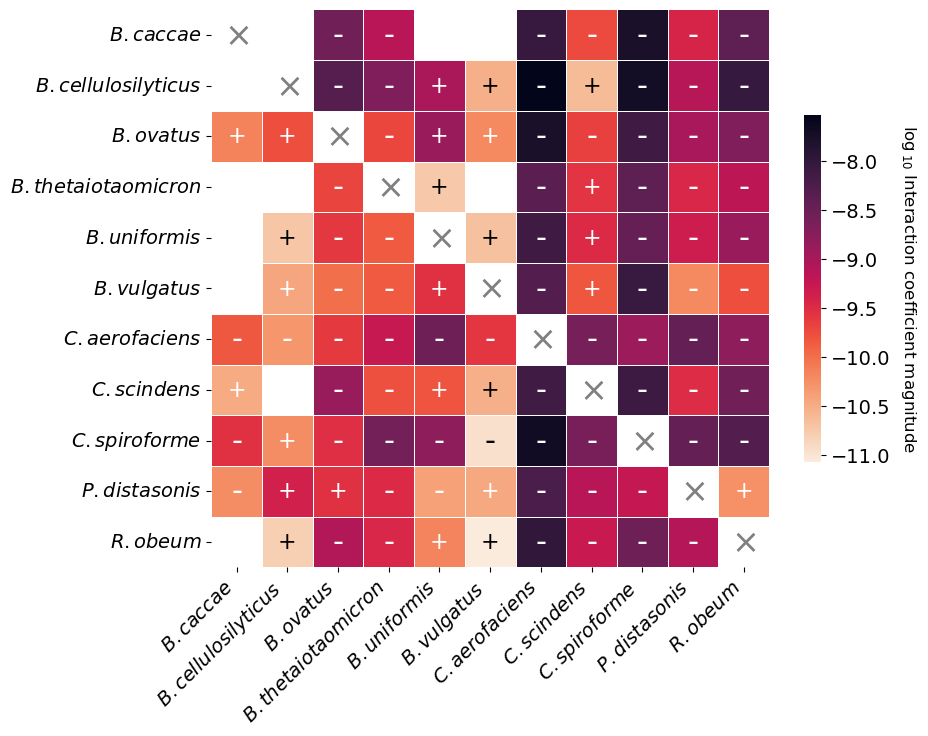

In [12]:
cmap = sns.color_palette("rocket_r", as_cmap=True)
matrix_lf0 = np.log10(np.absolute(masked_lf0))
plt.figure(figsize=(9,9))
ax = sns.heatmap(matrix_lf0, 
    cmap=cmap, 
    square=True, 
    cbar_kws={"shrink": .5}, 
    linewidths=0.5
    )
cbar = ax.collections[0].colorbar
cbar.set_label('$\log{}_{10}$ Interaction coefficient magnitude', rotation=270, fontsize=12, labelpad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
for i in range(len(masked_lf0)):
    for j in range(len(masked_lf0)):
        sign_col = 'k'
        if i == j:
            plt.text(j+0.5, i+0.5, '$\\times$', ha='center', va='center', color='gray', fontsize=24)
        elif np.isnan(masked_lf0).iloc[i, j]:
            plt.text(j+0.5, i+0.5, '', ha='center', va='center', fontsize=18)
        elif np.sign(masked_lf0).iloc[i, j] == 1.:
            if matrix_lf0.iloc[i, j] > -10.5:
                sign_col = 'w'
            plt.text(j+0.5, i+0.5, '+', ha='center', va='center', color=sign_col, fontsize=16)
        elif np.sign(masked_lf0).iloc[i, j] == -1.:
            if matrix_lf0.iloc[i, j] > -10.5:
                sign_col = 'w'
            plt.text(j+0.5, i+0.5, '-', ha='center', va='center', color=sign_col, fontsize=22)
plt.savefig('mcnulty-results/mcnulty-LF0-seed96/posteriors/interactions/interaction_matrix.svg', bbox_inches='tight')
plt.show()

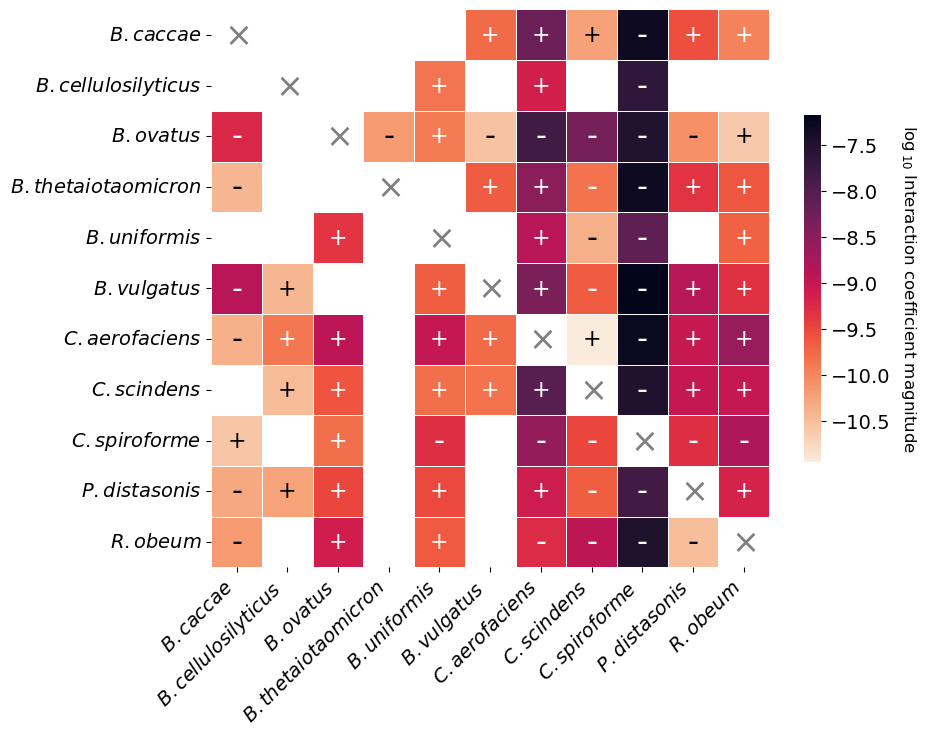

In [13]:
cmap = sns.color_palette("rocket_r", as_cmap=True)
matrix_hf0 = np.log10(np.absolute(masked_hf0))
plt.figure(figsize=(9,9))
ax = sns.heatmap(matrix_hf0, 
    cmap=cmap, 
    square=True, 
    cbar_kws={"shrink": .5}, 
    linewidths=0.5
    )
cbar = ax.collections[0].colorbar
cbar.set_label('$\log{}_{10}$ Interaction coefficient magnitude', rotation=270, fontsize=12, labelpad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
for i in range(len(masked_hf0)):
    for j in range(len(masked_hf0)):
        sign_col = 'k'
        if i == j:
            plt.text(j+0.5, i+0.5, '$\\times$', ha='center', va='center', color='gray', fontsize=24)
        elif np.isnan(masked_hf0).iloc[i, j]:
            plt.text(j+0.5, i+0.5, '', ha='center', va='center', fontsize=18)
        elif np.sign(masked_hf0).iloc[i, j] == 1.:
            if matrix_hf0.iloc[i, j] > -10:
                sign_col = 'w'
            plt.text(j+0.5, i+0.5, '+', ha='center', va='center', color=sign_col, fontsize=16)
        elif np.sign(masked_hf0).iloc[i, j] == -1.:
            if matrix_hf0.iloc[i, j] > -10:
                sign_col = 'w'
            plt.text(j+0.5, i+0.5, '-', ha='center', va='center', color=sign_col, fontsize=22)
plt.savefig('mcnulty-results/mcnulty-HF0-seed12/posteriors/interactions/interaction_matrix.svg', bbox_inches='tight')
plt.show()

In [26]:
transformed_interaction_matrix_lf0 = pd.DataFrame(tranform_interaction_matrix(interactions_lf0, inter_bayes_lf0), 
                                                  index=abbr_names, 
                                                  columns=abbr_names)
transformed_interaction_matrix_lf0.to_csv('mcnulty-results/mcnulty-LF0-seed96/posteriors/interactions/mean_matrix_transf.tsv', 
                                            sep='\t', 
                                            index=True, 
                                            header=True)
transformed_interaction_matrix_hf0 = pd.DataFrame(tranform_interaction_matrix(interactions_hf0, inter_bayes_hf0), 
                                                  index=abbr_names, 
                                                  columns=abbr_names)
transformed_interaction_matrix_hf0.to_csv('mcnulty-results/mcnulty-HF0-seed12/posteriors/interactions/mean_matrix_transf.tsv',
                                            sep='\t',
                                            index=True,
                                            header=True)

In [27]:
difference = np.absolute(np.log10(np.absolute(masked_lf0)) - np.log10(np.absolute(masked_hf0))) * np.sign(masked_lf0) * np.sign(masked_hf0)
mask = np.isnan(difference)

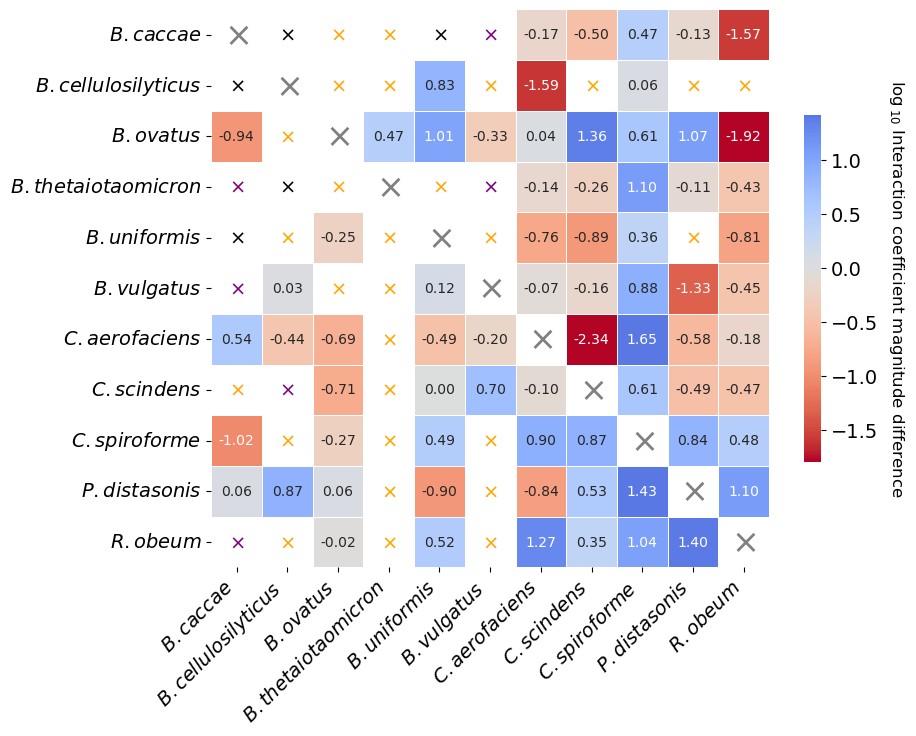

In [28]:
cmap = sns.color_palette("coolwarm_r", as_cmap=True)
plt.figure(figsize=(9,9))
ax = sns.heatmap(difference.fillna(0), 
    mask = mask, 
    cmap=cmap, 
    center=0, 
    square=True, 
    linewidths=0.5, 
    cbar_kws={"shrink": .5}, 
    annot=True, 
    fmt='.2f',
    annot_kws={"size": 10},
    robust=True
    )
for i in range(len(mask)):
    for j in range(len(mask)):
        if i == j:
            plt.text(j+0.5, i+0.5, '$\\times$', ha='center', va='center', color='gray', fontsize=24)
        elif (np.isnan(transformed_interaction_matrix_lf0).iloc[i, j]) & (not np.isnan(transformed_interaction_matrix_hf0).iloc[i, j]):
            plt.text(j+0.5, i+0.5, '$\\times$', ha='center', va='center', color = 'purple', fontsize=14)
        elif (not np.isnan(transformed_interaction_matrix_lf0).iloc[i, j]) & (np.isnan(transformed_interaction_matrix_hf0).iloc[i, j]):
            plt.text(j+0.5, i+0.5, '$\\times$', ha='center', va='center', color = 'orange', fontsize=14)
        elif (np.isnan(transformed_interaction_matrix_lf0).iloc[i, j]) & (np.isnan(transformed_interaction_matrix_hf0).iloc[i, j]):
            plt.text(j+0.5, i+0.5, '$\\times$', ha='center', va='center', fontsize=14)
cbar = ax.collections[0].colorbar
cbar.set_label('$\log{}_{10}$ Interaction coefficient magnitude difference', rotation=270, fontsize=12, labelpad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.savefig('mcnulty-results/interaction_matrix_diff.svg', bbox_inches='tight')
plt.show()

In [29]:
matrix1 = np.nan_to_num(transformed_interaction_matrix_lf0.values)
matrix2 = np.nan_to_num(transformed_interaction_matrix_hf0.values)

# matrix1 = np.nan_to_num(masked_lf0.values)
# matrix2 = np.nan_to_num(masked_hf0.values)

# Procrustes analysis
mtx1_trans, mtx2_trans, disparity = procrustes(matrix1, matrix2)

# Perform a permutation test

n_permutations = 10000
null_disparity = np.zeros(n_permutations)
for i in range(n_permutations):
    # Shuffle the rows of matrix2
    shuffled_matrix2 = np.random.permutation(matrix2)
    # shuffled_matrix2 = matrix2[np.random.permutation(matrix2.shape[0]), :]
    # Run Procrustes analysis on the shuffled matrix
    _, _, null_disparity[i] = procrustes(matrix1, shuffled_matrix2)

# Calculate p-value based on percentile of observed disparity value in null distribution
p_value_disp = percentileofscore(null_disparity, disparity) / 100

# Print the results
print(f"Disparity: {disparity:.4f}")
print(f"Disparity P-value: {p_value_disp:.4f}")

Disparity: 0.5433
Disparity P-value: 0.1188


In [30]:
permutation_test(matrix1.flatten(), matrix2.flatten(), method='approximate', num_rounds=10000, seed=0, paired=True)

9.999000099990002e-05

## Stability analysis

In [31]:
nodes_lf0 = pd.read_table('mcnulty-results/mcnulty-LF0-seed96/posteriors/nodes.tsv')
nodes_hf0 = pd.read_table('mcnulty-results/mcnulty-HF0-seed12/posteriors/nodes.tsv')

In [32]:
masked_lf0_ = masked_lf0.copy()
for i in range(len(nodes_lf0['Self_interaction_mean'])):
    masked_lf0_.iloc[i, i] = - nodes_lf0['Self_interaction_mean'].iloc[i]
    
masked_hf0_ = masked_hf0.copy()
for i in range(len(nodes_hf0['Self_interaction_mean'])):
    masked_hf0_.iloc[i, i] = - nodes_hf0['Self_interaction_mean'].iloc[i]

In [33]:
# np.sort(np.linalg.eig(np.nan_to_num(masked_.values))[0])
np.linalg.eig(np.nan_to_num(masked_lf0_.values))[0]

array([-8.75323356e-07, -3.26996804e-07, -8.75832801e-08, -5.34681594e-08,
       -3.89806570e-08, -5.25065035e-09, -4.81090793e-09, -1.34713248e-09,
       -2.15363374e-08, -1.54051367e-08, -1.85374365e-08])

In [34]:
# np.sort(np.linalg.eig(np.nan_to_num(masked_.values))[0])
np.linalg.eig(np.nan_to_num(masked_hf0_.values))[0]

array([-1.08239299e-06+0.00000000e+00j, -2.36712258e-07+0.00000000e+00j,
       -7.14263633e-08+0.00000000e+00j, -3.07434079e-08+0.00000000e+00j,
       -2.08346171e-08+0.00000000e+00j, -1.86162516e-08+0.00000000e+00j,
       -1.10779644e-08+1.72830931e-10j, -1.10779644e-08-1.72830931e-10j,
       -8.58309403e-09+0.00000000e+00j, -4.17672922e-09+0.00000000e+00j,
       -3.19462005e-09+0.00000000e+00j])

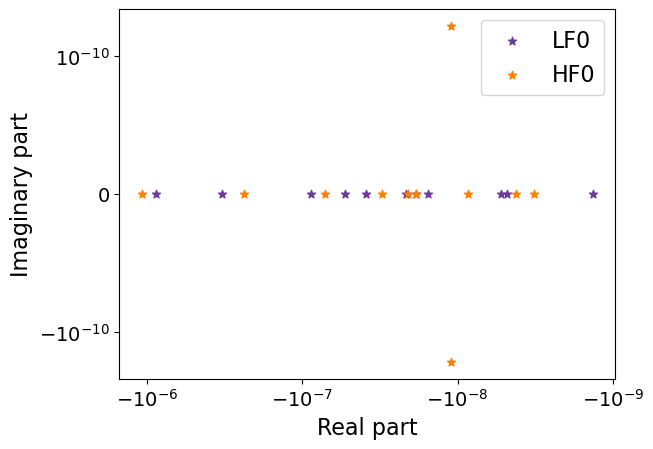

In [35]:
plt.scatter(np.real(np.linalg.eig(np.nan_to_num(masked_lf0_.values))[0]), 
    np.imag(np.linalg.eig(np.nan_to_num(masked_lf0_.values))[0]), 
    color=cm.Paired(9), 
    alpha=1, 
    marker='*',
    label='LF0')
plt.scatter(np.real(np.linalg.eig(np.nan_to_num(masked_hf0_.values))[0]), 
    np.imag(np.linalg.eig(np.nan_to_num(masked_hf0_.values))[0]), 
    color=cm.Paired(7), 
    alpha=1, 
    marker='*', 
    label='HF0')
plt.xscale('symlog', linthresh=10e-11)
plt.yscale('symlog', linthresh=10e-11)
plt.xlabel('Real part', fontsize=16)
plt.ylabel('Imaginary part', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.savefig('mcnulty-results/stability.svg', bbox_inches='tight')
plt.show()

## New matrix visualization

In [37]:
order_hm = ['Bce', 'Bov', 'Bth', 'Bvu', 'Bun', 'Bca', 'Pdi', 'Csc', 'Rob', 'Csp', 'Cae']

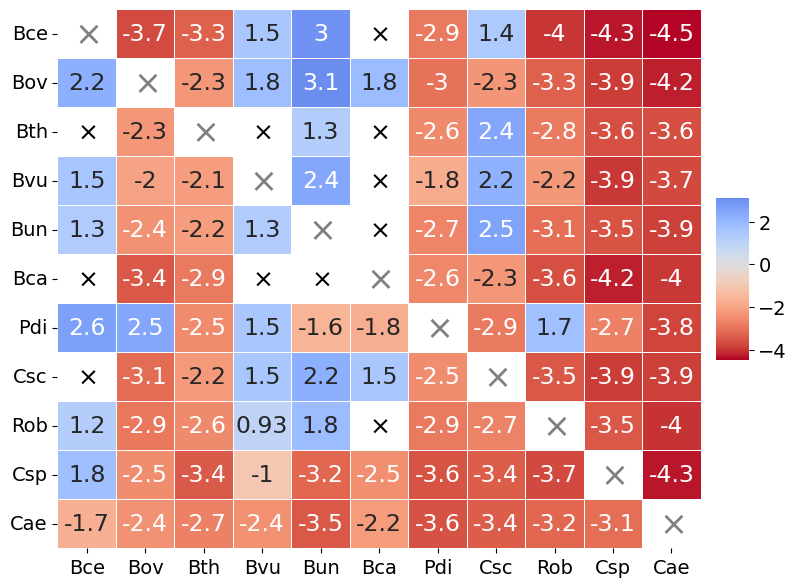

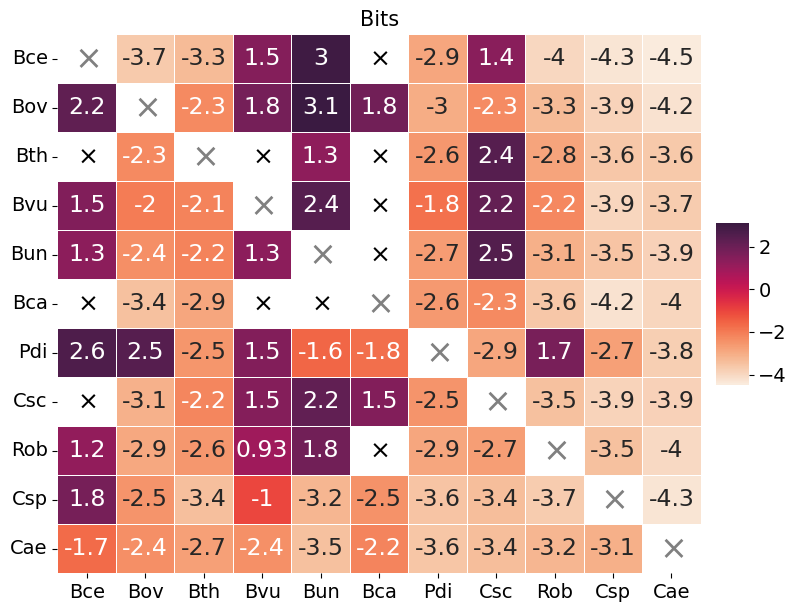

In [53]:
transformed_interaction_matrix_lf0 = transformed_interaction_matrix_lf0.loc[order_hm, order_hm]

cmap = sns.color_palette("coolwarm_r", as_cmap=True)
plt.figure(figsize=(10, 7))
ax = sns.heatmap(transformed_interaction_matrix_lf0, 
    cmap=cmap, 
    annot=True, 
    annot_kws={'size': 17},
    linewidths=0.5,
    center=0,
    cbar_kws={'shrink': 0.3, 'aspect': 5, 'orientation':'vertical', 'pad': 0.02},
    xticklabels=True,
    )
for i in range(len(transformed_interaction_matrix_lf0)):
    for j in range(len(transformed_interaction_matrix_lf0)):
        sign_col = 'k'
        if i == j:
            plt.text(j+0.5, i+0.5, '$\\times$', ha='center', va='center', color='gray', fontsize=24)
        elif np.isnan(transformed_interaction_matrix_lf0).iloc[i, j]:
            plt.text(j+0.5, i+0.5, '$\\times$', ha='center', va='center', fontsize=18)
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)
# plt.title('Bits', fontsize=15)
# plt.savefig('mcnulty-results/mcnulty-LF0-seed96/posteriors/interactions/interaction_matrix_transformed.svg', bbox_inches='tight')
plt.show()

cmap = sns.color_palette("rocket_r", as_cmap=True)
plt.figure(figsize=(10, 7))
ax = sns.heatmap(transformed_interaction_matrix_lf0, 
    cmap=cmap, 
    annot=True, 
    annot_kws={'size': 17},
    linewidths=0.5,
    center=0,
    cbar_kws={'shrink': 0.3, 'aspect': 5, 'orientation':'vertical', 'pad': 0.02},
    xticklabels=True,
    )
for i in range(len(transformed_interaction_matrix_lf0)):
    for j in range(len(transformed_interaction_matrix_lf0)):
        sign_col = 'k'
        if i == j:
            plt.text(j+0.5, i+0.5, '$\\times$', ha='center', va='center', color='gray', fontsize=24)
        elif np.isnan(transformed_interaction_matrix_lf0).iloc[i, j]:
            plt.text(j+0.5, i+0.5, '$\\times$', ha='center', va='center', fontsize=18)
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)
plt.title('Bits', fontsize=15)
# plt.savefig('mcnulty-results/mcnulty-LF0-seed96/posteriors/interactions/interaction_matrix_transformed.svg', bbox_inches='tight')
plt.show()

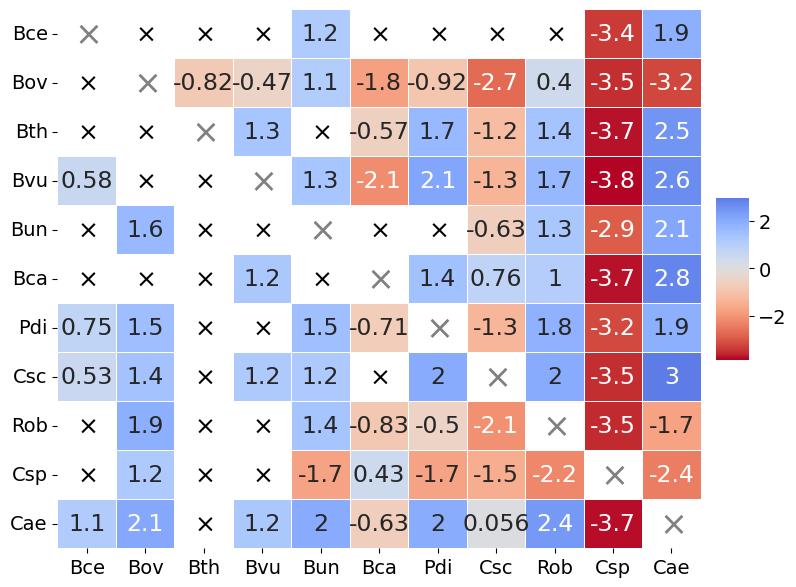

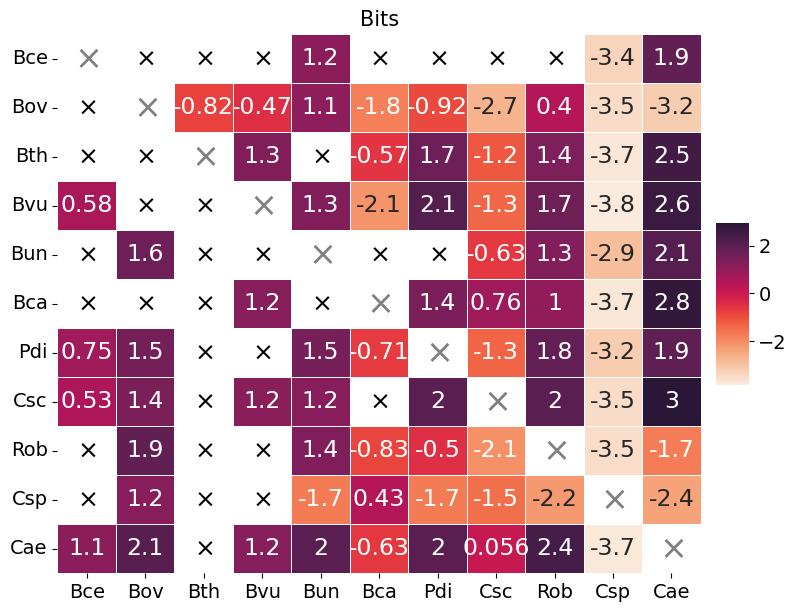

In [54]:
transformed_interaction_matrix_hf0 = transformed_interaction_matrix_hf0.loc[order_hm, order_hm]

cmap = sns.color_palette("coolwarm_r", as_cmap=True)
plt.figure(figsize=(10, 7))
ax = sns.heatmap(transformed_interaction_matrix_hf0, 
    cmap=cmap, 
    annot=True, 
    annot_kws={'size': 17},
    linewidths=0.5,
    center=0,
    cbar_kws={'shrink': 0.3, 'aspect': 5, 'orientation':'vertical', 'pad': 0.02},
    xticklabels=True,
    )
for i in range(len(transformed_interaction_matrix_hf0)):
    for j in range(len(transformed_interaction_matrix_hf0)):
        sign_col = 'k'
        if i == j:
            plt.text(j+0.5, i+0.5, '$\\times$', ha='center', va='center', color='gray', fontsize=24)
        elif np.isnan(transformed_interaction_matrix_hf0).iloc[i, j]:
            plt.text(j+0.5, i+0.5, '$\\times$', ha='center', va='center', fontsize=18)
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)
# plt.title('Bits', fontsize=15)
# plt.savefig('mcnulty-results/mcnulty-LF0-seed96/posteriors/interactions/interaction_matrix_transformed.svg', bbox_inches='tight')
plt.show()

cmap = sns.color_palette("rocket_r", as_cmap=True)
plt.figure(figsize=(10, 7))
ax = sns.heatmap(transformed_interaction_matrix_hf0, 
    cmap=cmap, 
    annot=True, 
    annot_kws={'size': 17},
    linewidths=0.5,
    center=0,
    cbar_kws={'shrink': 0.3, 'aspect': 5, 'orientation':'vertical', 'pad': 0.02},
    xticklabels=True,
    )
for i in range(len(transformed_interaction_matrix_hf0)):
    for j in range(len(transformed_interaction_matrix_hf0)):
        sign_col = 'k'
        if i == j:
            plt.text(j+0.5, i+0.5, '$\\times$', ha='center', va='center', color='gray', fontsize=24)
        elif np.isnan(transformed_interaction_matrix_hf0).iloc[i, j]:
            plt.text(j+0.5, i+0.5, '$\\times$', ha='center', va='center', fontsize=18)
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)
plt.title('Bits', fontsize=15)
# plt.savefig('mcnulty-results/mcnulty-LF0-seed96/posteriors/interactions/interaction_matrix_transformed.svg', bbox_inches='tight')
plt.show()